# Analysis functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import re
import pandas as pd

color_scheme = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                               '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
#Helper funtions
def to_seconds(time_series):
  split_string = lambda timestring: re.split(':', timestring)
  time = [float(split_string(value)[0])*3600 + float(split_string(value)[1])*60 + float(split_string(value)[2]) for value in time_series]
  return time

def timeToSec(time):
    pc = re.split(':',time)
    return int(pc[0])*3600 + int(pc[1])*60 + int(pc[2])

def lookupCondition(columnHeader, conds):
    keys = conds.keys()
    count = 0
    out = ""
    for e in conds.values():
        if columnHeader in e:
            count += 1
            out = list(conds.keys())[list(conds.values()).index(e)]
    assert(count <= 1)
    
    return out

def plotCalibratedAverages(level, x, ax, data, conditions, fit, color_dict, format_dict=None):
    data_list = []
    for i, c in enumerate(data.columns):
        col = c 
        if i>= 2 and lookupCondition(col, conditions) == level:
            ynew = [(float(x) - fit[0])/fit[1] for x in data[col].values]
            data_list.append(ynew)
            
    data_array = np.array(data_list)
    y_mean = np.mean(data_array, axis=0)
    y_std = np.std(data_array, axis=0)
    
    lab = 'Av' + level
    color = color_dict[level] if level in color_dict else 'blue' # set default color to blue

    if format_dict is None:
        format_dict = {'point_size': 1, 'point_opacity': 0.6, 'fill_opacity': 0.5}

    point_size = format_dict.get('point_size', 1)
    point_opacity = format_dict.get('point_opacity', 0.6)
    fill_opacity = format_dict.get('fill_opacity', 0.5)

    ax.scatter(x, y_mean, label=lab, color=color, alpha=point_opacity, s=[point_size]*len(y_mean))
    ax.fill_between(x, y_mean - y_std, y_mean + y_std, color=color, alpha=fill_opacity)

 
  
def completion_at_time(data,
                      control_data,
                      time_list_seconds,
                      time_in_seconds,
                      conditions,
                      control_conditions,
                      base_line_level,
                      triggered_level,
                      experimental_level,
                      verbose = False):
  data = data
  conditions = conditions
  control_data = control_data
  control_conditions = control_conditions

  def progegate_uncertainty_averaged_stddev(std_dev_list):
    return np.sqrt(sum(s**2 for s in std_dev_list)/(len(std_dev_list)**2))

  def average_last_n_with_std(n, average_series, std_series):
    av = average_series[-n:].mean()
    std = progegate_uncertainty_averaged_stddev(std_series[-n:].values)
    return av, std
  def calculate_completion_level(V, T, B):
    return (float(V) - float(B))/(float(T) - float(B))
  def series_av_and_std(dat, cond, level_name):
    target_columns = cond[level_name]
    dat[target_columns] = dat[target_columns].apply(pd.to_numeric)
    average_by_point = dat[target_columns].mean(axis=1)
    std_by_point = dat[target_columns].std(axis=1)
    return average_by_point, std_by_point

  #Get the x-values in seconds
  x = time_list_seconds
  #Fine the index of the first datapoint greater than time in seconds
  desired_time_index = min([i for i, time in enumerate(x) if time >= time_in_seconds])
  #Fist calculate baseline average and uncertainty at LAST AVAILABLE 5 DATAPOINTS
  base_line_average, base_line_std = average_last_n_with_std(5, *series_av_and_std(control_data, control_conditions, base_line_level))
  #Next calculate the triggering average and uncerainty at LAST 5 AVAILABLE DATAPOINTS
  triggered_average, triggered_std = average_last_n_with_std(5, *series_av_and_std(control_data, control_conditions, triggered_level))
  completion_levels = []
  for l_name in conditions[experimental_level]:
    completion_levels += [calculate_completion_level(data[l_name][desired_time_index], triggered_average, base_line_average)]

  if verbose:
    print(f"{experimental_level} : {np.average(completion_levels)} +/- {np.std(completion_levels)}")
  return np.average(completion_levels), np.std(completion_levels)


# Importing data

In [2]:
UW_no = pd.read_csv("UW_LongOH_NoInc.csv")
conditions_UW_no = {'baseline nn2' : ['B2', 'C2', 'D2'],
                    'no background nn2' : ['B3', 'C3', 'D3'],
                    'N50_25uM nn2' : ['B5', 'C5', 'D5'],
                    'N25_25uM nn2' : ['B7', 'C7', 'D7'],
                    'baseline nn1' : ['E2', 'F2', 'G2'],
                    'no background nn1' : ['E3', 'F3', 'G3'],
                    'N50_25uM nn1' : ['E5', 'F5', 'G5'],
                    'N25_25uM nn1' : ['E7', 'F7', 'G7']}
offset_UW_no = 180
t_UW_no = [offset_UW_no  + timeToSec(i) for i in list(UW_no['Time'].values)]


UW_rep = pd.read_csv("UW_LongOH_RepInc.csv")
conditions_UW_rep = {'baseline nn2' : ['B8', 'C8', 'D8'],
                    'no background nn2' : ['B9', 'C9', 'D9'],
                    'N50_25uM nn2' : ['B11', 'C11', 'D11'],
                    'N25_25uM nn2' : ['B13', 'C13', 'D13'],
                    'baseline nn1' : ['E8', 'F8', 'G8'],
                    'no background nn1' : ['E9', 'F9', 'G9'],
                    'N50_25uM nn1' : ['E11', 'F11', 'G11'],
                    'N25_25uM nn1' : ['E13', 'F13', 'G13']}
offset_UW_rep = 180
t_UW_rep = [offset_UW_rep + timeToSec(i) for i in list(UW_rep['Time'].values)]


# Processing data

In [3]:
time_point = 3600*6

t = t_UW_no
data = UW_no
conditions = conditions_UW_no
controls = data

UW_no_nn1_N25_25uM = completion_at_time(data, controls, t, time_point, conditions, conditions,'baseline nn1', 'no background nn1', 'N25_25uM nn1', verbose = True)
UW_no_nn1_N50_25uM = completion_at_time(data, controls, t, time_point, conditions, conditions,'baseline nn1', 'no background nn1', 'N50_25uM nn1', verbose = True)
UW_no_nn2_N25_25uM = completion_at_time(data, controls, t, time_point, conditions, conditions,'baseline nn2', 'no background nn2', 'N25_25uM nn2', verbose = True)
UW_no_nn2_N50_25uM = completion_at_time(data, controls, t, time_point, conditions, conditions,'baseline nn2', 'no background nn2', 'N50_25uM nn2', verbose = True)
UW_no_diff_N25_25uM = [(UW_no_nn2_N25_25uM[0] - UW_no_nn1_N25_25uM[0]), np.sqrt(UW_no_nn2_N25_25uM[1]**2 + UW_no_nn1_N25_25uM[1]**2)]
UW_no_diff_N50_25uM = [(UW_no_nn2_N50_25uM[0] - UW_no_nn1_N50_25uM[0]), np.sqrt(UW_no_nn2_N50_25uM[1]**2 + UW_no_nn1_N50_25uM[1]**2)]
print(f"diff_N25_25uM: {UW_no_diff_N25_25uM[0]} +/- {UW_no_diff_N25_25uM[1]}")
print(f"diff_N50_25uM: {UW_no_diff_N50_25uM[0]} +/- {UW_no_diff_N50_25uM[1]}")

N25_25uM nn1 : 0.861602688350862 +/- 0.0022609643201381502
N50_25uM nn1 : 0.8769139016641626 +/- 0.012515027198158092
N25_25uM nn2 : 0.8782474147329933 +/- 0.009610330449234124
N50_25uM nn2 : 0.919242756296598 +/- 0.0077224557272001434
diff_N25_25uM: 0.016644726382131325 +/- 0.009872710418138189
diff_N50_25uM: 0.04232885463243541 +/- 0.014705856936241529


In [4]:
time_point = 3600*6

t = t_UW_rep
data = UW_rep
conditions = conditions_UW_rep

controls = data

UW_rep_nn1_N25_25uM = completion_at_time(data, controls, t, time_point, conditions, conditions,'baseline nn1', 'no background nn1', 'N25_25uM nn1', verbose = True)
UW_rep_nn1_N50_25uM = completion_at_time(data, controls, t, time_point, conditions, conditions,'baseline nn1', 'no background nn1', 'N50_25uM nn1', verbose = True)
UW_rep_nn2_N25_25uM = completion_at_time(data, controls, t, time_point, conditions, conditions,'baseline nn2', 'no background nn2', 'N25_25uM nn2', verbose = True)
UW_rep_nn2_N50_25uM = completion_at_time(data, controls, t, time_point, conditions, conditions,'baseline nn2', 'no background nn2', 'N50_25uM nn2', verbose = True)
UW_rep_diff_N25_25uM = [(UW_rep_nn2_N25_25uM[0] - UW_rep_nn1_N25_25uM[0]), np.sqrt(UW_rep_nn2_N25_25uM[1]**2 + UW_rep_nn1_N25_25uM[1]**2)]
UW_rep_diff_N50_25uM = [(UW_rep_nn2_N50_25uM[0] - UW_rep_nn1_N50_25uM[0]), np.sqrt(UW_rep_nn2_N50_25uM[1]**2 + UW_rep_nn1_N50_25uM[1]**2)]
print(f"diff_N25_25uM: {UW_rep_diff_N25_25uM[0]} +/- {UW_rep_diff_N25_25uM[1]}")
print(f"diff_N50_25uM: {UW_rep_diff_N50_25uM[0]} +/- {UW_rep_diff_N50_25uM[1]}")

N25_25uM nn1 : 0.8921265349067243 +/- 0.011710989450304679
N50_25uM nn1 : 0.8898269311945968 +/- 0.0035497502813508883
N25_25uM nn2 : 0.9202579745084963 +/- 0.0122433092645234
N50_25uM nn2 : 0.9408176127567661 +/- 0.011894296988821952
diff_N25_25uM: 0.028131439601772 +/- 0.016942428859284372
diff_N50_25uM: 0.05099068156216935 +/- 0.012412696238861631


# Figures

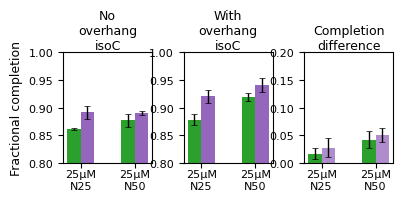

=== One-sample t-tests: each completion difference vs 0 (with Holm correction) ===
N25, no incubation: t = 2.920, raw p = 0.09999, Holm p = 0.2
N25, reporter incubation: t = 2.876, raw p = 0.1026, Holm p = 0.1026
N50, no incubation: t = 4.985, raw p = 0.03796, Holm p = 0.1139
N50, reporter incubation: t = 7.115, raw p = 0.01919, Holm p = 0.07674


In [8]:
fig, ax = plt.subplots(1, 3)
fig.set_figwidth(3.75)
fig.set_figheight(1.5)

# Reduce whitespace and expand axes area
plt.subplots_adjust(
    left=0.10,   # default ~0.125 → expand
    right=0.98,
    top=0.92,
    bottom=0.18,
    wspace=0.35  # reduce inter-panel whitespace
)

labels = [u"25\u03bcM\nN25", u"25\u03bcM\nN50"]
x = np.arange(len(labels))
bar_width = 0.25

datasets_panel0 = [
    ([UW_no_nn1_N25_25uM, UW_no_nn1_N50_25uM],
     [UW_no_nn2_N25_25uM, UW_no_nn2_N50_25uM],
     color_scheme[2], 1.0),

    ([UW_rep_nn1_N25_25uM, UW_rep_nn1_N50_25uM],
     [UW_rep_nn2_N25_25uM, UW_rep_nn2_N50_25uM],
     color_scheme[4], 1),
]

datasets_panel1 = [
    ([UW_no_diff_N25_25uM, UW_no_diff_N50_25uM], color_scheme[2], 1.0),
    ([UW_rep_diff_N25_25uM, UW_rep_diff_N50_25uM], color_scheme[4], 0.75),
]

error_params = dict(ecolor='black', lw=1, capsize=2.5, capthick=0.5)

# --- Panels 0 and 1 ---
for i, (nn1_list, nn2_list, color, scale) in enumerate(datasets_panel0):
    dx = (i - 0.5) * bar_width

    # Panel 0
    nn1_y = [v[0] for v in nn1_list]
    nn1_err = [v[1] for v in nn1_list]
    ax[0].bar(x + dx, nn1_y, width=bar_width, yerr=nn1_err,
              color=color, alpha=scale, error_kw=error_params)

    # Panel 1
    nn2_y = [v[0] for v in nn2_list]
    nn2_err = [v[1] for v in nn2_list]
    ax[1].bar(x + dx, nn2_y, width=bar_width, yerr=nn2_err,
              color=color, alpha=scale, error_kw=error_params)

# --- Panel 2: diff ---
for i, (diff_list, color, scale) in enumerate(datasets_panel1):
    dx = (i - 0.5) * bar_width
    diff_y = [v[0] for v in diff_list]
    diff_err = [v[1] for v in diff_list]
    ax[2].bar(x + dx, diff_y, width=bar_width, yerr=diff_err,
              color=color, alpha=scale, error_kw=error_params)

# --- Formatting ---
for a in ax:
    a.set_xticks(x)
    a.set_xticklabels(labels, fontsize=8)
    a.tick_params(axis='x', labelrotation=0, pad=1)
    for spine in a.spines.values():
        spine.set_visible(True)

ax[0].set_ylim(0.8, 1)
ax[1].set_ylim(0.8, 1)
ax[2].set_ylim(0, 0.2)

ax[0].set_ylabel('Fractional completion', fontsize=9)
for a in ax:
    a.set_xticklabels(labels, fontsize=9)
    a.tick_params(axis='both', labelsize=8)


ax[0].set_title('No\noverhang\nisoC', fontsize=9, pad=2)
ax[1].set_title('With\noverhang\nisoC', fontsize=9, pad=2)
ax[2].set_title('Completion\ndifference', fontsize=9, pad=2)

plt.savefig('NAR_longOH.svg', dpi=600)
plt.show()

import numpy as np
from scipy.stats import t

print("=== One-sample t-tests: each completion difference vs 0 (with Holm correction) ===")

# Adjust if your number of replicates per bar is different
n_reps = 3

# Each entry: (label, (mean, std))
bars = [
    ("N25, no incubation",       UW_no_diff_N25_25uM),
    ("N25, reporter incubation", UW_rep_diff_N25_25uM),
    ("N50, no incubation",       UW_no_diff_N50_25uM),
    ("N50, reporter incubation", UW_rep_diff_N50_25uM),
]

def one_sample_t_from_stats(mean, std, n, mu0=0.0):
    """One-sample t-test from summary stats."""
    t_stat = (mean - mu0) / (std / np.sqrt(n))
    df = n - 1
    p_val = 2 * (1 - t.cdf(abs(t_stat), df))
    return t_stat, p_val

raw_pvals = []
results = []

for label, (mean_val, std_val) in bars:
    t_stat, p_val = one_sample_t_from_stats(mean_val, std_val, n_reps, mu0=0.0)
    raw_pvals.append(p_val)
    results.append((label, t_stat, p_val))

# Holm correction across the 4 tests
m = len(raw_pvals)
sorted_idx = sorted(range(m), key=lambda i: raw_pvals[i])
holm_p = [None] * m

for rank, idx in enumerate(sorted_idx, start=1):
    adj = raw_pvals[idx] * (m - rank + 1)
    holm_p[idx] = min(1.0, adj)

for (label, t_stat, p_raw), p_adj in zip(results, holm_p):
    print(f"{label}: t = {t_stat:.3f}, raw p = {p_raw:.4g}, Holm p = {p_adj:.4g}")
